In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

# Importing Data

In [2]:
df = pd.read_csv('zillow_data.csv')
df.rename(columns={'RegionName':'zipcode'}, inplace=True)
df.head()

,RegionID,zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


Calculate growth here

### Focusing on homes in Arizona

In [3]:
df = df[df['State']=='AZ']

Number of Unique Zipcodes in Arizona: 230

In [4]:
df['zipcode'].value_counts().sum()

230

# Reshaping Data

In [5]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['zipcode', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [6]:
melted = melt_data(df)
melted = melted.set_index('time')
melted.shape

(58775, 8)

In [7]:
melted = melted['2009-04-01':'2018-04-01']

### Grouping By zipcode

In [8]:
grouped = melted.groupby(['zipcode','time']).aggregate({'value':'mean'})
grouped

value
zipcode time                
85003   2009-04-01  256400.0
        2009-05-01  247600.0
        2009-06-01  240900.0
        2009-07-01  236300.0
        2009-08-01  233300.0
...                      ...
86442   2017-12-01  152000.0
        2018-01-01  153600.0
        2018-02-01  154700.0
        2018-03-01  155500.0
        2018-04-01  156200.0

[24851 rows x 1 columns]

### Trying to add ZHVI forecasted growth over the years

Growth = 100 * [ ZHVI_{this month current year} – ZHVI_{this month last year} ] / [ ZHVI_{this month last year} ]

### Resampling to Monthly

In [9]:
resampled = melted.groupby('zipcode').resample('M').mean().drop('zipcode',axis=1)
resampled

RegionID  SizeRank     value
zipcode time                                    
85003   2009-04-30     94719      8043  256400.0
        2009-05-31     94719      8043  247600.0
        2009-06-30     94719      8043  240900.0
        2009-07-31     94719      8043  236300.0
        2009-08-31     94719      8043  233300.0
...                      ...       ...       ...
86442   2017-12-31     95213      1989  152000.0
        2018-01-31     95213      1989  153600.0
        2018-02-28     95213      1989  154700.0
        2018-03-31     95213      1989  155500.0
        2018-04-30     95213      1989  156200.0

[24851 rows x 3 columns]

### Trying out Facebook Prophet Forecasting on Zipcode: 85003

In [10]:
import warnings
warnings.simplefilter('ignore')

from fbprophet import Prophet

In [11]:
model = Prophet(interval_width=0.95,weekly_seasonality=True, daily_seasonality=True)

In [12]:
zipcode_85003 = resampled.loc[85003]
zipcode_85003.rename(columns={'value':'y'},inplace=True)
zipcode_85003.index.name = 'ds'
zipcode_85003 = zipcode_85003.reset_index()
zipcode_85003 = zipcode_85003[['ds','y']]
zipcode_85003

,ds,y
0,2009-04-30,256400.0
1,2009-05-31,247600.0
2,2009-06-30,240900.0
3,2009-07-31,236300.0
4,2009-08-31,233300.0
...,...,...
104,2017-12-31,434900.0
105,2018-01-31,439500.0
106,2018-02-28,442300.0
107,2018-03-31,441400.0


In [13]:
model.fit(zipcode_85003)

Trying to forecast home value for the next 60 months (or 5 years)

In [14]:
future = model.make_future_dataframe(periods=5*12,freq='M')

In [15]:
forecast = model.predict(future)

In [16]:
forecast[['ds','yhat']].tail()

,ds,yhat
164,2022-12-31,589818.853923
165,2023-01-31,592600.419680
166,2023-02-28,595802.081058
167,2023-03-31,599110.671656
168,2023-04-30,601368.221500


### Plotting zipcode series

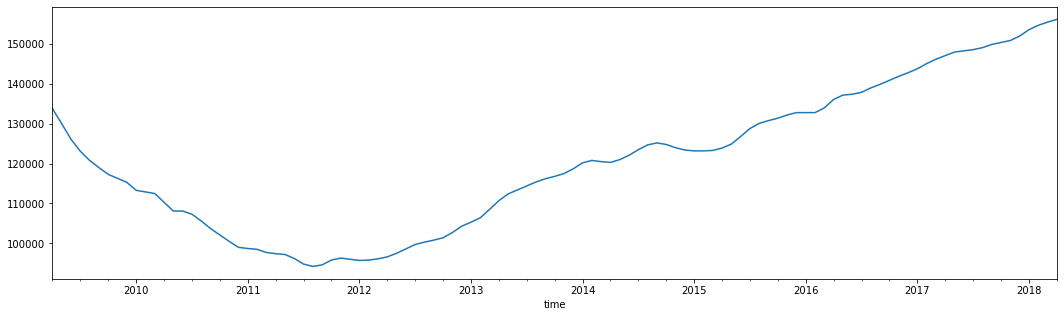

In [17]:
def plot_zip(zipcode):
    series = resampled.loc[zipcode,'value']
    fig, ax = plt.subplots(figsize=(18,5))
    series.plot(ax=ax);
    
plot_zip(86442)

In [18]:
def stationarity_check(TS):
    dftest = adfuller(TS)
    
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

In [19]:
stationarity_check(resampled.loc[86442,'value'])

Results of Dickey-Fuller Test: 

Test Statistic                  -0.554584
p-value                          0.880918
#Lags Used                       8.000000
Number of Observations Used    100.000000
Critical Value (1%)             -3.497501
Critical Value (5%)             -2.890906
Critical Value (10%)            -2.582435
dtype: float64
